In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.utils
import torchvision
import cv2
import time
import util

In [2]:
f = h5py.File('./data/sample_A_20160501.hdf', 'r')

<img src="./hierarchy.png">

### *Hierarchy of /annotations/* 

In [3]:
print("The shape of /annotations/ids is", f['/annotations/ids'].shape)
print("The shape of /annotations/locations is", f['/annotations/locations'].shape)
print("The shape of /annotations/types is", f['/annotations/types'].shape)
print("The shape of /annotations/presynaptic_site/partners is", f['/annotations/presynaptic_site/partners'].shape)
print("The shape of /annotations/comments/comments is", f["/annotations/comments/comments"].shape)
print("The shape of /annotations/comments/target_ids is", f["/annotations/comments/target_ids"].shape)

The shape of /annotations/ids is (432,)
The shape of /annotations/locations is (432, 3)
The shape of /annotations/types is (432,)
The shape of /annotations/presynaptic_site/partners is (216, 2)
The shape of /annotations/comments/comments is (17,)
The shape of /annotations/comments/target_ids is (17,)


### *Hierarchy of /volumes/* 

In [4]:
print("The shape of /volumes/labels/neuron_ids is", f['/volumes/labels/neuron_ids'].shape)
print("The shape of /volumes/labels/clefts is", f['/volumes/labels/neuron_ids'].shape)
print("The shape of /volumes/raw is", f['/volumes/raw'].shape)

The shape of /volumes/labels/neuron_ids is (125, 1250, 1250)
The shape of /volumes/labels/clefts is (125, 1250, 1250)
The shape of /volumes/raw is (125, 1250, 1250)


## *volume examples*

In [5]:
# fig, axs = plt.subplots(10, 10, figsize = (20,20))
# for i in range(100):
#     axs[i//10,i%10].imshow(f['/volumes/raw'][i])

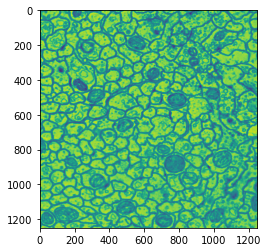

In [6]:
plt.imshow(f['/volumes/raw'][0])

## *autoencoder blocks*
#### there are 125 images in each volume

In [7]:
if torch.cuda.is_available(): device = torch.device("cuda")
else: device = torch.device("cpu")
print(f"device = {device}")

device = cuda


In [8]:
train_x = torch.tensor(f['/volumes/raw'])
dummy_y = torch.zeros(train_x.shape[0])

In [9]:
print(torch.cuda.memory_allocated()//(1024*1024))
train_x = train_x.unsqueeze(1).to(device)
print(torch.cuda.memory_allocated()//(1024*1024))
# train_x = torchvision.transforms.functional.normalize(train_x.float(), 0.5, 0.5)

dataset_ae = torch.utils.data.TensorDataset(train_x.float(), dummy_y)

0
186


In [32]:
num_epochs = 10
batch_size = 16
learning_rate = 1e-3

ae_dataloader = torch.utils.data.DataLoader(dataset_ae, batch_size=batch_size)

# O = (W−F+2P)/S+1
# (O - 1) * S - 2P + F = W
class autoencoder(torch.nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(1, 16, 3, stride=3, padding=2),  # b, 16, 418, 418
            torch.nn.ReLU(True),
            torch.nn.MaxPool2d(2, stride=2),  # b, 16, 209, 209
            torch.nn.Conv2d(16, 8, 3, stride=2),  # b, 8, 104, 104
            torch.nn.ReLU(True),
            torch.nn.MaxPool2d(2, stride=2)  # b, 8, 52, 52
        )
        self.decoder = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(8, 16, 3, stride=3),  # b, 16, 156, 156
            torch.nn.ReLU(True),
            torch.nn.ConvTranspose2d(16, 16, 3, stride=2),  # b, 16, 156, 156
            torch.nn.ReLU(True),
            torch.nn.ConvTranspose2d(16, 8, 3, stride=2),  # b, 8, 15, 15
            torch.nn.ReLU(True),
            torch.nn.ConvTranspose2d(8, 1, 4, stride=2, padding=3),  # b, 1, 28, 28
            torch.nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


model = autoencoder().cuda()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,
                             weight_decay=1e-5, eps=1e-4)

In [33]:
def deconv(size, stride, padding, Filter):
    '''compute deconv size: deconv(size, stride, padding, Filter)'''
    return (size - 1) * stride - 2 * padding + Filter

In [34]:
def conv(size, stride, padding, Filter):
    '''compute conv size: conv(size, stride, padding, Filter)'''
    return (size - Filter + 2 * padding)/stride + 1

In [55]:
torch.cuda.empty_cache()

In [36]:
model.train()
for epoch in range(num_epochs):
    for img,_ in ae_dataloader:
        output = model(img)
        loss = criterion(output, img)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print('epoch [{}/{}], loss:{:.4f}'
      .format(epoch+1, num_epochs, loss.item()))
    
#     if epoch % 2 == 0:
#         pic = to_img(output.cpu().data)
#         torchvison.save_image(pic, './ae_dst/image_{}.png'.format(epoch))
torch.save(model.state_dict(), './EM_autoencoder.pth')

epoch [1/10], loss:16665.9316
epoch [2/10], loss:16641.8086
epoch [3/10], loss:16559.4902
epoch [4/10], loss:16476.7285
epoch [5/10], loss:16465.4062
epoch [6/10], loss:16465.3359
epoch [7/10], loss:16465.3320
epoch [8/10], loss:16465.3320
epoch [9/10], loss:16465.3301
epoch [10/10], loss:16465.3262


In [58]:
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 1250, 1250)
    return x
dst = to_img(output)
print(dst.shape)

torch.Size([13, 1, 1250, 1250])


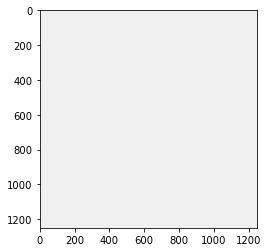

In [54]:
plt.imshow(dst[0,0,:,:].detach().cpu(), cmap = 'gray', vmax = 1, vmin = 0)